# Evolution of red sequence on WaZP DP0 clusters

### Andressa Wille 

#### Universidade Tecnológica Federal do Paraná (UTFPR)
#### Laboratório Interinstitucional de e-Astronomia (LIneA)


## Objectives & Research Question:
* Study the red fraction evolution of members of WaZP clusters on DP0;
* Evaluate the performance of the WaZP algorithm, depending on input data;
* What is the impact of photo-z uncertainties on the red sequence evolution?  

## Background:
The Wavelet Z Photometric (WaZP) is an optical cluster finder that detects clusters using photometric redshift information. The algorithm can be used to select cluster members to study different aspects in cluster evolution, as the color-magnitude diagram feature named red sequence.


## Methodology:

Imports

In [40]:
import numpy as np 
import matplotlib.pyplot as plt
import pylab as pl
import scipy.stats as stats
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
import sys
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.integrate import quad
from scipy.special import erf
import sqlalchemy
from gavodb import DBManager

%matplotlib inline

### QAs

Links para processos no Portal:
* Photo-z training: https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7028
* Photo-z compute: https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7030 
* VAC cosmo DC2: https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7011
* VAC DP0: https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7032

Plots: photo-z (zphot vs zspec, N(z)),  vac (footprint (ra x dec), mag dist, photo-z N(z), mag vs photo-z).

In [ ]:
dbm = DBManager()

#### Photo-z training

In [3]:
photoz_training = dbm.get_tablelist_from_pid('7028')

In [4]:
photoz_training

[]

#### Photo-z compute

In [5]:
photoz_comp = dbm.get_tablelist_from_pid('7030')

In [6]:
photoz_comp

['photoz_compute.dnf_7030']

In [ ]:
columns = ['z_best','err_z']
photoz_comp = dbm.get_db_table('photoz_compute.dnf_7030', columns)

#### VAC DC2

In [10]:
vac_dc2_tables = dbm.get_tablelist_from_pid('7011')

In [11]:
vac_dc2_tables

['vac_cluster_simulation.footprint_7011',
 'vac_cluster_simulation.catalog_7011']

In [12]:
vac_dc2 = dbm.get_db_table('vac_cluster_simulation.footprint_7011', ['ra', 'dec'])

In [ ]:
vac2_dc2 = dbm.get_db_table('vac_cluster_simulation.catalog_7011', ['ra', 'dec', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'])

In [13]:
vac_dc2

array([[ 50.40527344,  51.28417969,  50.5480957 , ...,  74.63012695,
         61.66625977,  65.22172949],
       [-34.42082925, -37.46203997, -35.27306975, ..., -29.35598753,
        -35.3645019 , -42.27282242]])

In [14]:
vac_dataframe = pd.DataFrame(data=vac_dc2)

In [15]:
vac_dataframe = vac_dataframe.T

In [16]:
vac_dataframe.columns = ['ra', 'dec']

In [17]:
vac_dataframe

,ra,dec
0,50.405273,-34.420829
1,51.284180,-37.462040
2,50.548096,-35.273070
3,52.404785,-37.697382
4,49.592285,-35.238809
...,...,...
2149849,49.416504,-39.777742
2149850,73.081055,-28.599121
2149851,74.630127,-29.355988
2149852,61.666260,-35.364502


In [18]:
dc2 = vac_dataframe

#### DP0

In [ ]:
vac_dc2_tables = dbm.get_tablelist_from_pid('7032')

#### Photo-z x spec-z

In [ ]:
plt.plot(dc2['z_photo'], dc2['z_spec'], 'k.')
plt.xlabel("photo-z")
plt.ylabel("spec-z")
plt.title("Redshift")
plt.grid(True)
plt.tight_layout()

#### Footprint RA x DEC

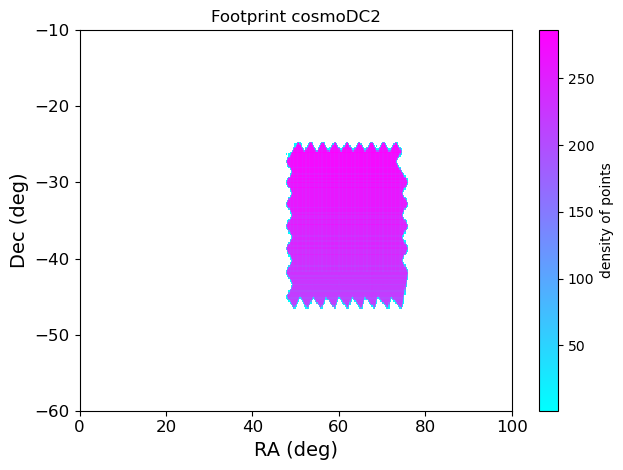

In [19]:
#Area = 441.41

ra = dc2['ra']
ra[ra >180.0] -= 360
dec = dc2['dec']
plt.hist2d(ra, dec, bins=100, weights=None, cmin=0.5, cmax=None, cmap='cool')
plt.xlabel("RA (deg)", fontsize=14)
plt.ylabel("Dec (deg)", fontsize=14)
plt.colorbar(label="density of points")
ylims=[-60, -10]
plt.ylim(ylims)
xlims=[0, 100]
plt.xlim(xlims)
#plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Footprint cosmoDC2', fontsize=12)
plt.tight_layout()

#### N(z)

In [ ]:
plt.hist(dc2['z_best'], bins='auto', ec="cornflowerblue", fc="cornflowerblue")
plt.xlabel("z")
plt.ylabel("Counts")
plt.title("Redshift Distribution")
plt.grid(True)
plt.tight_layout()

#### Mags dis

In [ ]:
bands = ['g', 'r', 'i', 'z', 'y']

for i, band in enumerate(bands):
    plt.figure()
    plt.hist(dc2[f'mag_{band}'], histtype='bar', bins='auto', ec="cornflowerblue")
    plt.xlabel("mag "+band)
    plt.ylabel("Counts")
    plt.xlim(10, 40)
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()

#### Mag x z

In [ ]:
for i, band in enumerate(bands):
    pl.figure(figsize=[10,4])
    pl.subplot(121) 
    mag = np.array(dc2[f'mag_{band}'])
    z = np.array(dc2['z_best'])
    mask = (mag>14)&(mag<32)&(z<=2)
    pl.hexbin(z[mask], mag[mask], None,  mincnt=1, cmap='viridis', gridsize=[200,100], bins='log')
    cbar = pl.colorbar()
    pl.xlabel("mag "+band)
    pl.ylabel("redshift")
    pl.grid(True)
    pl.tight_layout()


### Data: 
* Catalogs of WaZP cluster members in DC2 (truth mags, truth z) and DP0 ("observed" mags, photo-z DNF);
* Truth DC2 halo members catalog, used as reference.


_______________________________________
^ a análise do catálogo truth é um pouco diferente, achei melhor deixar em outro notebook.
___________________________________________

Choose one of the catalogs to start the analysis.

In [41]:
#DP0 catalog
wazp_membership = Table.read('/archive/user/aguena/cats/dp0/wazp/7038/wazp_membership.fits', format='fits')
#print(wazp_membership.colnames)

In [35]:
#DC2 catalog
wazp_membership = Table.read('/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/wazp/6948/wazp_membership.fits', format='fits')

In [ ]:
#truth catalog
halos = Table.read('/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0_members_nfwpmem.fits', format='fits')
print(halos.colnames)

Magnitude cut $m_{r}^{*}$

In [42]:
data = np.loadtxt('/archive/user/aguena/cats/dc2/mstar/DC2_z_star.dat')
mstar = spline(*data[data[:,0]<2].T)

Data selection

Select magnitude bands and richness.

In [43]:
mag1 = 'r'
mag2 = 'i'

ngals_min = 25
#ngals_max = 25

mask_mag = (wazp_membership['mag_z']<=mstar(wazp_membership['ZP'])+1.5)
mask_rich = (wazp_membership['NGALS']>ngals_min)#&(wazp_membership['NGALS']<ngals_max)

Arrays to save red fractions and errors

In [44]:
fraction = []
fraction_err = []
photozs = []

### Color magnitude diagrams:

Select the redshift interval to plot CMDs.

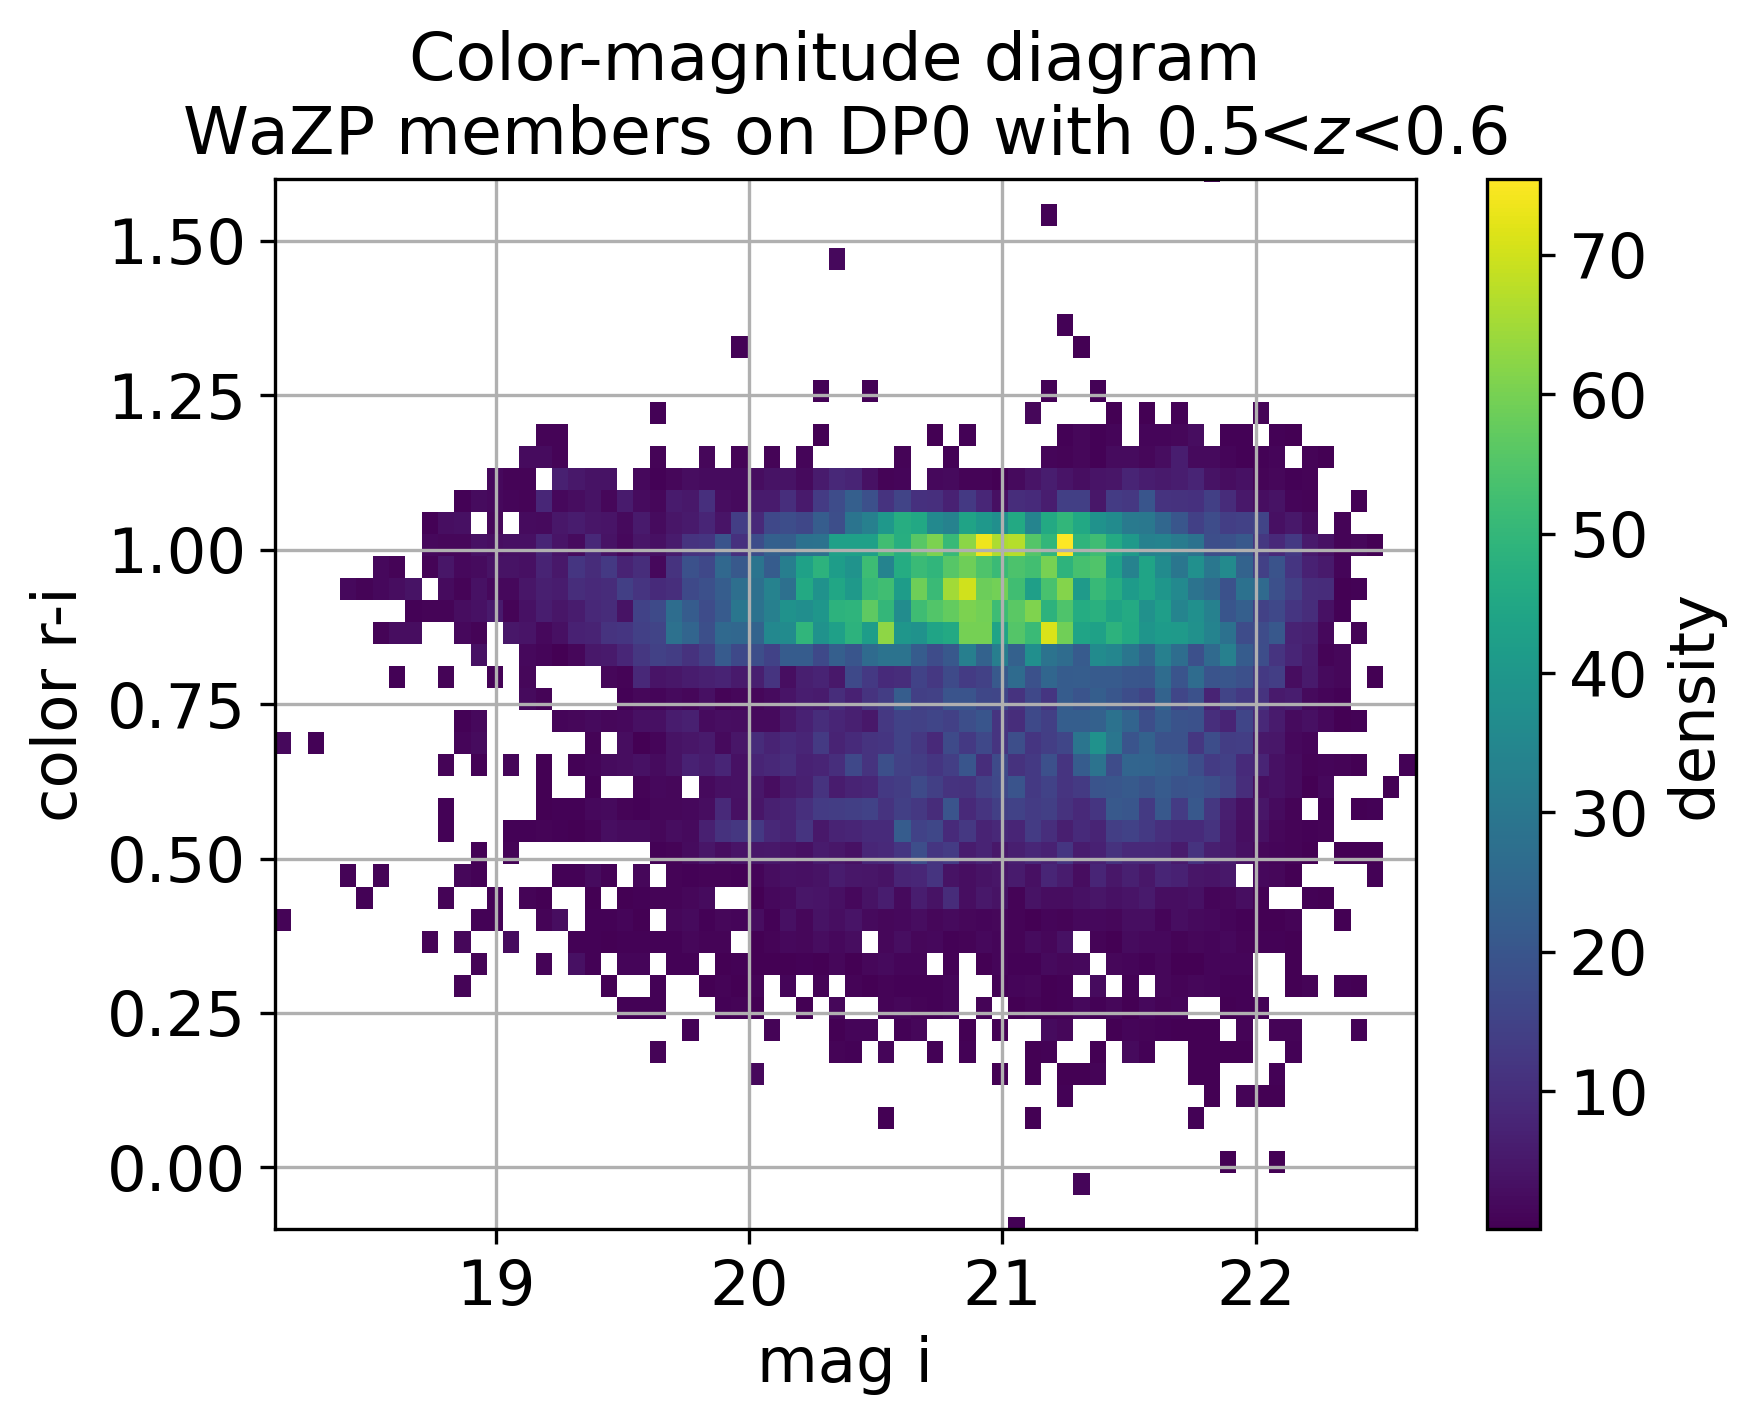

In [49]:
plt.rcParams['font.size'] = 15

plt.figure(figsize=[6,5], dpi=300)

zpmax = 0.6
zpmin = 0.5

Nbins = 1 #int(10*(zpmax-zpmin))
dz = (zpmax - zpmin)/Nbins

#print(dz)

for j in range(0, Nbins):
    z1 = zpmin + (j * dz)
    z2 = z1 + dz
    round(z1,1)
    round(z2,1)
    #print(z1, z2)
    
    mask_z = (wazp_membership['ZP']>z1)&(wazp_membership['ZP']<z2)
    mask = (mask_rich)&(mask_z)&(mask_mag) 


    #plt.figure(figsize=[8,5])#, dpi=300)
    wazp_membership_color = wazp_membership[f'mag_{mag1}'][mask] - wazp_membership[f'mag_{mag2}'][mask]
    color = np.array(wazp_membership_color)
    mag = np.array(wazp_membership[f'mag_{mag2}'][mask])
    pmem = np.array(wazp_membership['PMEM'][mask])
    plt.hist2d(mag, color, bins=70, weights=pmem, cmin=0.1, cmax=None, cmap='viridis')
    cbar = pl.colorbar(label="density")
    
    #plt.xlim()
    plt.ylim(-0.1, 1.6)

    plt.title(f'Color-magnitude diagram \nWaZP members on DP0 with {round(z1,1)}<$z$<{round(z2,1)}', fontsize=16)
    plt.xlabel('mag '+mag2)
    plt.ylabel(f'color {mag1}-{mag2}')
    plt.grid(True)
    #plt.legend()
    #plt.savefig('fig1.png')
    plt.tight_layout()

### Analysis:
* After selecting the richness range and the magnitudes, we have to separate the data in redshift bins.
* The red and blue populations were characterized by Gaussian distributions on color histograms. We chose the colors that envelop the 4000 Å break. The 4000 Å break is caused by the absorption of high energy radiation from metals in stellar atmospheres and by a deficiency of hot, blue stars. That implies the presence of old stellar populations.
    We have the following distribution of colors: $0.1 < z < 0.2$ in g-r, $0.3 < z < 0.6$ in r-i, $0.7 < z < 1.0$ in i-z, $1.1 < z < 1.4$ in z-y.

* We integrated the curves to find the number of red and total members and calculate the red fraction in each redshift bin.

Select color.

In [50]:
mag1 = 'r'
mag2 = 'i'

Define gaussian fit and integral.

Gaussian params: A, $\mu$ and $\sigma$ are the height, width and center of the gaussians, respectively.

In [51]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [52]:
def gauss_integral(y):
    return A2*np.exp(-(y-mu2)**2/2/sigma2**2)
def gauss2_integral(y):
    return (A1*np.exp(-(y-mu1)**2/2/sigma1**2)+A2*np.exp(-(y-mu2)**2/2/sigma2**2))

Select redshift interval.

In [53]:
z1 = 0.5
z2 = 0.6
photoz = (z1 + z2)/2

Plot color histograms and fit gaussians for selected redshift bin.
See expected_params.txt to complete the values in "expected" array.

In [ ]:
mask_z = (wazp_membership['ZP']>z1)&(wazp_membership['ZP']<z2)
mask = (mask_rich)&(mask_z)&(mask_mag) 

wazp_membership_color = wazp_membership[f'mag_{mag1}'] - wazp_membership[f'mag_{mag2}']
color = np.array(wazp_membership_color[mask])
pmem = np.array(wazp_membership['PMEM'][mask])

plt.figure(figsize=[8,5])
y,x,_=plt.hist(color, bins=30, weights=pmem, density=True, fc="moccasin", ec='sandybrown', label='color distribution')
x=(x[1:]+x[:-1])/2
x=x.reshape(-1, 1)

expected = (0.6, 0.1, 10.0, 0.95, 0.15, 50.0)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)

plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='model')
plt.plot(x_fit, gauss(x_fit, *params[0:3]), color='blue', lw=2, ls="--", label='blue population')
plt.plot(x_fit, gauss(x_fit, *params[3:6]), color='red', lw=2, ls="--", label='red population')
plt.title(f'Color histogram ({round(z1,1)}<$z$<{round(z2,1)})', fontsize=12)
plt.legend(fontsize=11)
plt.ylabel('number of galaxies')
plt.xlabel(f'{mag1}-{mag2}')
plt.grid(True)
data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
print(data)
plt.show() 

print(data.to_numpy())
mu1 = data.to_numpy()[0][0]
sigma1 = data.to_numpy()[1][0]
A1 = data.to_numpy()[2][0]
mu2 = data.to_numpy()[3][0]
sigma2 = data.to_numpy()[4][0]
A2 = data.to_numpy()[5][0]

mu1_err = data.to_numpy()[0][1]
sigma1_err = data.to_numpy()[1][1]
A1_err = data.to_numpy()[2][1]
mu2_err = data.to_numpy()[3][1]
sigma2_err = data.to_numpy()[4][1]
A2_err = data.to_numpy()[5][1]

Propagating errors according to the general equation: 
$\sigma_{w}^2 = (\frac{\partial w}{\partial x})^2 \sigma_{x}^2 + (\frac{\partial w}{\partial y})^2 \sigma_{y}^2 + (\frac{\partial w}{\partial z})^2 \sigma_{z}^2 + ...$


$(\frac{\partial w}{\partial x})^2 \sigma_{x}^2 = (\frac{\partial}{\partial A}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}})^2 \sigma_{A}^2 = (\sqrt{\frac{\pi}{2}}\, \sigma \, erf(\frac{x-\mu}{\sigma \sqrt{2}}))^2 \sigma_{A}^2$ -> erro 1


$(\frac{\partial w}{\partial y})^2 \sigma_{y}^2 = (\frac{\partial}{\partial \mu}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}})^2 \sigma_{\mu}^2 = (-A e^{\frac{-(\mu-x)^2}{2\sigma ^2}})^2 \, \sigma_{\mu}^2$ -> erro 2


$(\frac{\partial w}{\partial z})^2 \sigma_{z}^2 = (\frac{\partial}{\partial \sigma}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}})^2 \sigma_{\sigma}^2 = (\frac{A(\mu - x) e^{\frac{-(x-\mu)^2}{2\sigma ^2}}}{\sigma} - \sqrt{\frac{\pi}{2}} \, A \, erf(\frac{\mu - x}{\sigma \sqrt{2}}))^2 \sigma_{\sigma}^2$ -> erro 3

In [ ]:
erro1 = ((np.sqrt(np.pi/2))*sigma2*erf((mu2-x.max())/(sigma2*np.sqrt(2)))) - ((np.sqrt(np.pi/2))*sigma2*erf((mu2-x.min())/(sigma2*np.sqrt(2))))
erro1 = (erro1**2) * (A2_err)**2
print(erro1)

erro2 = (-A2* np.exp(-(mu2-x.max())**2/2/sigma2**2)) - (-A2* np.exp(-(mu2-x.min())**2/2/sigma2**2))
erro2 = (erro2**2) * (mu2_err)**2
print(erro2)

erro3_1 = ((A2*(mu2-x.max()* np.exp(-(mu2-x.max())**2/2/sigma2**2)))/(sigma2) -A2*np.sqrt(np.pi/2)*erf((mu2-x.max())/(sigma2*np.sqrt(2))))
erro3_2 = ((A2*(mu2-x.min()* np.exp(-(mu2-x.min())**2/2/sigma2**2)))/(sigma2) -A2*np.sqrt(np.pi/2)*erf((mu2-x.min())/(sigma2*np.sqrt(2))))
erro3 = erro3_1 - erro3_2
erro3 = (erro3**2) * (sigma2_err)**2
print(erro3)

#erro gaussiana vermelha
erro_r = np.sqrt(erro1+erro2+erro3)
print(erro_r)

erro4 = ((np.sqrt(np.pi/2))*sigma1*erf((mu1-x.max())/(sigma1*np.sqrt(2)))) - ((np.sqrt(np.pi/2))*sigma1*erf((mu1-x.min())/(sigma1*np.sqrt(2))))
erro4 = (erro4**2) * (A1_err)**2
print(erro4)

erro5 = (-A1* np.exp(-(mu1-x.max())**2/2/sigma1**2)) - (-A1* np.exp(-(mu1-x.min())**2/2/sigma1**2))
erro5 = (erro5**2) * (mu1_err)**2
print(erro2)

erro6_1 = ((A1*(mu1-x.max()* np.exp(-(mu1-x.max())**2/2/sigma1**2)))/(sigma1) -A1*np.sqrt(np.pi/2)*erf((mu1-x.max())/(sigma1*np.sqrt(2))))
erro6_2 = ((A1*(mu1-x.min()* np.exp(-(mu1-x.min())**2/2/sigma1**2)))/(sigma1) -A1*np.sqrt(np.pi/2)*erf((mu1-x.min())/(sigma1*np.sqrt(2))))
erro6 = erro6_1 - erro6_2
erro6 = (erro6**2) * (sigma1_err)**2
print(erro6)

#erro gaussiana azul
erro_b = np.sqrt(erro4+erro4+erro6)
print(erro_b)

#erro gaussiana total
erro = np.sqrt(erro1+erro2+erro3+erro4+erro4+erro6)
print(erro)

General results:

In [ ]:
print(f'{round(z1,1)}<z<{round(z2,1)}')
n_red_galaxies, n_red_galaxies_err = quad(gauss_integral, x.min(), x.max())
print(f'number of red galaxies:{n_red_galaxies} +- {erro_v}')
n_galaxies, n_galaxies_err = quad(gauss2_integral, x.min(), x.max())
print(f'number of galaxies:{n_galaxies} +- {erro}')
red_fraction = n_red_galaxies/n_galaxies
red_fraction_err = (n_red_galaxies/n_galaxies)* np.sqrt((erro_v/n_red_galaxies)**2+(erro/n_galaxies)**2)
print(f'red fraction:{red_fraction} +- {red_fraction_err}')

Save fractions in a txt file.

In [ ]:
fraction.append(red_fraction)
fraction_err.append(red_fraction_err)
photozs.append(photoz)

In [ ]:
out = np.transpose([photozs, fraction, fraction_err])
name = 'dp0_fractions.txt' #change the name of the catalog.
np.savetxt(name, out, header='redshift   fractions   errors', fmt='%1.6e')

## Preliminary Results:

Plot a figure to see the evolution of red fraction with redshift for the sample analyzed.


In [ ]:
#read file
doc = 'dp0_fractions.txt'
redshifts1, fractions1, fractions_err1= np.loadtxt(doc, usecols=(0,1,2), unpack=True)
doc2 = 'dp0_fractions_35.txt'
redshifts2, fractions2, fractions_err2= np.loadtxt(doc2, usecols=(0,1,2), unpack=True)
doc3 = 'dp0_fractions_50.txt'
redshifts3, fractions3, fractions_err3= np.loadtxt(doc3, usecols=(0,1,2), unpack=True)

#dados do is_on_red_sequence
fractions = [0.5921440352216439,
 0.4642129461578483,
 0.4789826401939994,
 0.6606916236992021,
 0.641815640391323,
 0.44747444997980507,
 0.651031839816072,
 0.5323493468171591,
 0.5322468325080284,
 0.4176714023569384,
 0.4403604511825388,
 0.42375264278427704,
 0.3133637322335352]

fractions_err = [0.1472829857276373,
 0.03801613952846332,
 0.04836953657826101,
 0.026204572223403992,
 0.022289734202544854,
 0.02229797364575938,
 0.03471092178715547,
 0.03341395373284115,
 0.022290112387518414,
 0.01901494321516365,
 0.030791916110973,
 0.01509076032375121,
 0.024954069152175483]

plt.rcParams['font.size'] = 15

plt.figure(figsize=[6,6], dpi=300)

plt.plot(redshifts1, fractions1, 'o', color='green', label='25<Ngals<35')
plt.errorbar(redshifts1, fractions1, yerr=fractions_err1, color='green', fmt='.')
plt.plot(redshifts2, fractions2, 's', color='yellowgreen', label='35<Ngals<50')
plt.errorbar(redshifts2, fractions2, yerr=fractions_err2, color='yellowgreen', fmt='.')
plt.plot(redshifts3, fractions3, 'x', color='teal', label='Ngals>50')
plt.errorbar(redshifts3, fractions3, yerr=fractions_err3, color='teal', fmt='.')
plt.plot(redshifts3, fractions, '^', color='black', label='"is_on_red_sequence_ri"')
plt.errorbar(redshifts3, fractions, yerr=fractions_err, color='black', fmt='.')
plt.xlabel("redshift")
plt.ylabel("red fraction")
plt.ylim(-0.1, 1.2)
plt.xlim(0.1, 1.4)
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3])
plt.yticks([0.0, 0.4, 0.8, 1.2])
plt.title("Red fraction in WaZP DP0 clusters (color r-i)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('dp0.png')


## Discussion:
* The first and last redshift bins have larger error bars because fewer objects are selected and the gaussian fit is not so precise.
* The red fraction evolution observed in wazp cluster members recovers the overall trend of the galaxies marked as "is on red sequence" in the truth catalog for color r-i.
* The reasonable agreement between DC2 and DP0 results shows that introducing photo-z-related uncertainties in the WaZP cluster detection does not change the overall trend of red fraction evolution.

## Conclusions:

* As WaZP does not rely on the red sequence information, its good performance in detecting clusters with a low fraction of red galaxies makes the algorithm suitable for studies of cluster properties at high redshifts.
* In future works, we intend to investigate the evolution of the red slope.

## Future Works:


We have some preliminar results in the investigation of the inclination of the red sequence - the red slope.

In [ ]:
def green_valley(mu1, sigma1, A1, mu2, sigma2, A2):
    g_pos = ((mu1*sigma2**2 - mu2*sigma1**2)+np.sqrt((mu1*sigma2**2 - mu2*sigma1**2)**2 - (sigma2**2-sigma1**2)*(sigma2**2*mu1**2 - sigma1**2*mu2**2 -2*sigma1**2*sigma2**2*np.log(A1/A2))))/(sigma2**2-sigma1**2)
    g_neg = ((mu1*sigma2**2 - mu2*sigma1**2)-np.sqrt((mu1*sigma2**2 - mu2*sigma1**2)**2 - (sigma2**2-sigma1**2)*(sigma2**2*mu1**2 - sigma1**2*mu2**2 -2*sigma1**2*sigma2**2*np.log(A1/A2))))/(sigma2**2-sigma1**2)
    
    return (g_pos, g_neg)

def redseq_fit(mag, color):
    fit_result = stats.linregress(mag, color)
    a = fit_result.slope
    b = fit_result.intercept
    a_err = fit_result.stderr
    xfit = np.arange(10, 30, 1)
    yfit = a*xfit + b
    
    return a, b, a_err, xfit, yfit

wazp_membership_color = wazp_membership[f'mag_true_{mag1}'][mask] - wazp_membership[f'mag_true_{mag2}'][mask]
color = np.array(wazp_membership_color)
mag = np.array(wazp_membership[f'mag_true_{mag2}'][mask])
pmem = np.array(wazp_membership['pmem_nfw2d'][mask])

x = color.reshape(-1, 1)

green_line1, green_line2 = green_valley(mu1, sigma1, A1, mu2, sigma2, A2)
#if z1==1.0 or z1==1.1 or z1==1.2 or z1==1.3:
#    green_line = green_line2
#else:
green_line = green_line1

plt.rcParams['font.size'] = 15

plt.figure(figsize=[6,6], dpi=300)
#plt.subplot(121) 
plt.hist2d(mag, color, bins=70, weights=pmem, cmin=0.5, cmax=None, cmap='viridis')
cbar = pl.colorbar()

red = (color>=green_line)
# first fit
a1, b1, a1_err, xfit1, yfit1 = redseq_fit(mag[red], color[red])
c1 = np.mean(mag)
b2 = green_line - a1*c1
y2 = a1*xfit1 + b2
plt.plot(xfit1, yfit1, 'r--', lw=1.0)
plt.plot(xfit1, y2, 'g-', lw=1.0)

red2 = (color>=((a1*mag)+b2))
# second fit
a, b, a_err, xfit, yfit = redseq_fit(mag[red2], color[red2])
slope.append(a)
slope_err.append(a_err)
plt.plot(xfit, yfit, 'r-', lw=1.5, label=f'red slope {round(a,5)} +- {round(a_err,5)}')
plt.hlines(green_line, 16.5, 24.5, linestyles='dashed', color='green')
    
plt.title(f'Red sequence fit for {round(z1,1)}<z<{round(z2,1)}')
plt.xlabel('mag '+mag2)
plt.ylabel(f'{mag1}-{mag2}')
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()

## Acknowledgement: 
I would like to thank J. Gschwend, M. Aguena, C. Benoist and L. da Costa for the supervision and LSST Corporation for the financial support.

___________________________________________________________________________________
To-do:
    
    * Incluir análise do catálogo truth -> outro notebook
    * Arrumar o expected_params.txt para os bins de richness
    * Adicionar seção de Future Works com a análise inicial da red slope
    * Verificar quais bibliotecas nos imports não são necessárias